## Notebook para realizar la parte 2 del TFM: clasificación de imágenes según tipo de célula sanguínea

Se tiene de entrada el dataset ____ y de salida se espera tener el acc del modelo

In [2]:
from glob import glob 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

img_width, img_height = 224, 224
batch_size = 32

In [3]:
import random
random.seed(42)
from numpy.random import seed
seed(42)

In [4]:
train_data_dir = '../../dataset/classification/PCB_Dataset_Split/train'
validation_data_dir = '../../dataset/classification/PCB_Dataset_Split/val'

folders = glob('../../dataset/classification/PCB_Dataset_Split/train/*')

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [6]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=60,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    vertical_flip = True,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
  
val_datagen = ImageDataGenerator(rescale = 1. / 255)
  
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    keep_aspect_ratio = True,
    batch_size = batch_size,
    class_mode = 'categorical')
  
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    keep_aspect_ratio = True,
    batch_size = batch_size,
    class_mode = 'categorical')

Found 13671 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.


In [7]:
nb_train_samples = 13671 

nb_validation_samples = 1705 

Found 13671 files belonging to 8 classes.


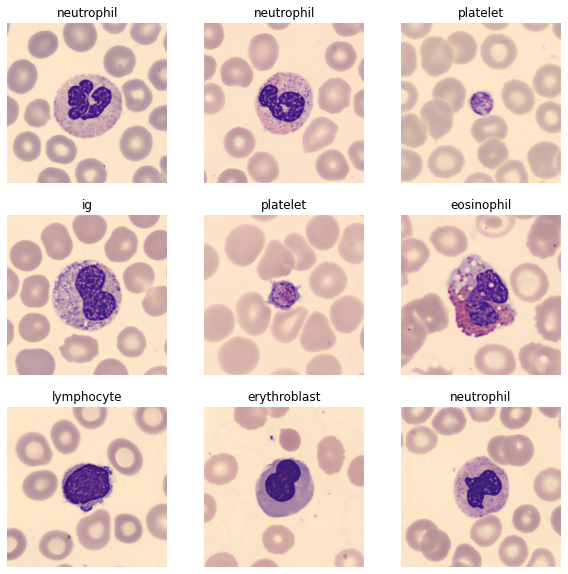

In [8]:
train_dataset = image_dataset_from_directory(train_data_dir,
                                             shuffle = True,
                                             batch_size = batch_size,
                                             image_size = (img_width, img_height))

class_name =  train_dataset.class_names

plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [9]:
# Modelo de prueba CNN

# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. 
#This will be replaced with images classes we have. 
vgg = VGG19(input_shape = [img_width, img_height] + [3], weights = 'imagenet', include_top = False)

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines 
#can be ommitted. 
for layer in vgg.layers:
    layer.trainable = True

x = vgg.output
#x = MaxPooling2D()(x)
x = Flatten()(x)
#x = Dense(4096, activation='relu')(x)
#x = Dense(1072, activation='relu')(x)
#x = Dropout(0.2)(x)
prediction = Dense(len(folders), activation = 'softmax')(x) 

model = Model(inputs = vgg.input, outputs = prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(learning_rate = 0.001, momentum = 0.9, nesterov = False),
              metrics = ['accuracy'])

In [11]:
epochs = 25

es = EarlyStopping(monitor = 'val_loss', 
                   mode = 'min', 
                   verbose = 1, 
                   patience = 3)

mc = ModelCheckpoint('../../model/classification/vgg19_trainable_true_best_model.h5',
                     verbose = 1,
                     monitor = 'val_loss', 
                     mode = 'min', 
                     save_best_only = True)

lr_red = ReduceLROnPlateau(monitor = 'val_loss', 
                           patience = 2,
                           verbose = 1,
                           mode = 'min',
                           factor = 0.1, 
                           min_lr = 1e-7)

In [12]:
history = model.fit(
                    train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    epochs = epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples // batch_size,
                    callbacks = [es, mc, lr_red])

Epoch 1/25
427/427 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8586
Epoch 1: val_loss improved from inf to 0.13494, saving model to best_model.h5
427/427 [==============================] - 693s 2s/step - loss: 0.4067 - accuracy: 0.8586 - val_loss: 0.1349 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 2/25
427/427 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9634
Epoch 2: val_loss improved from 0.13494 to 0.12528, saving model to best_model.h5
427/427 [==============================] - 635s 1s/step - loss: 0.1106 - accuracy: 0.9634 - val_loss: 0.1253 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 3/25
427/427 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9760
Epoch 3: val_loss improved from 0.12528 to 0.09700, saving model to best_model.h5
427/427 [==============================] - 636s 1s/step - loss: 0.0753 - accuracy: 0.9760 - val_loss: 0.0970 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 4/25
427/427 [===============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


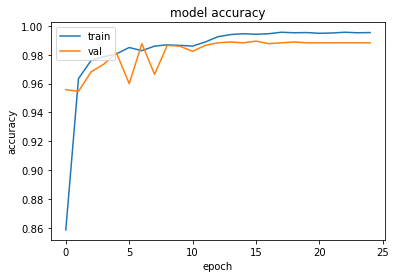

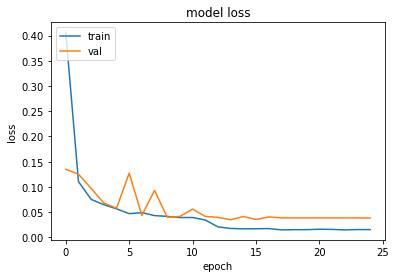

In [13]:
# Printeamos las gráficas de acc y loss
print(history.history.keys())

# acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Guardamos el modelo
model.save(
    '../../model/classification/image_classification_CNN.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)